[*********************100%***********************]  7 of 7 completed


Minimum Variance Portfolio: Weights [0.058 0.166 0.373 0.01  0.208 0.14  0.046]
Expected Return: 0.3786, Volatility: 0.1502, Sharpe Ratio: 2.5192

Tangency (Sharpe Optimal) Portfolio: Weights [0.173 0.22  0.146 0.16  0.093 0.208 0.   ]
Expected Return: 0.5507, Volatility: 0.1793, Sharpe Ratio: 3.0690



[*********************100%***********************]  1 of 1 completed
<ipython-input-1-2e6a5b7c4602>:161: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nifty50_mean_return = nifty50_returns.mean()[0] * NUM_TRADING_DAYS
<ipython-input-1-2e6a5b7c4602>:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nifty50_volatility = nifty50_returns.std()[0] * np.sqrt(NUM_TRADING_DAYS)


NIFTY50 Index: Expected Return: 0.2515, Volatility: 0.0975, Sharpe Ratio: 2.5771



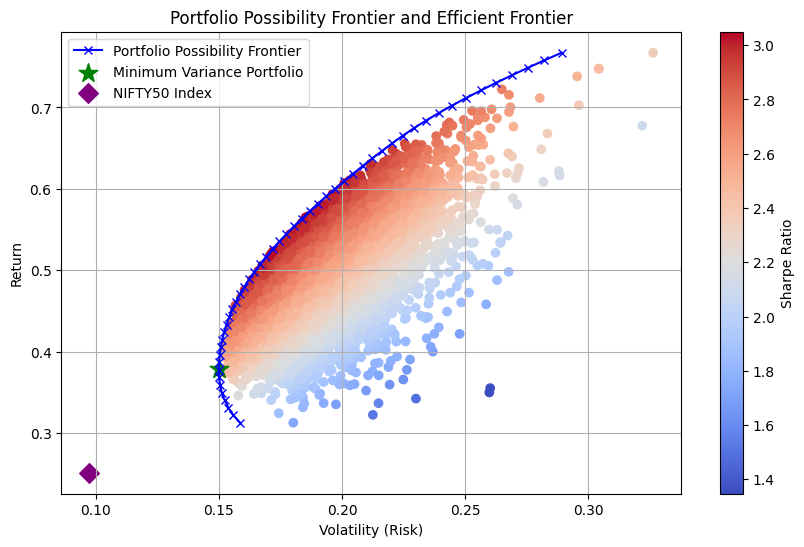

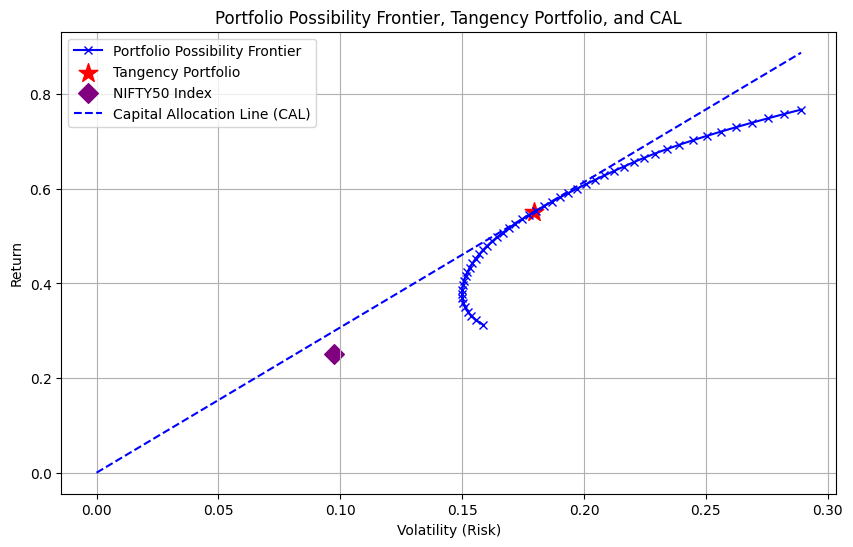

In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

# Constants
NUM_TRADING_DAYS = 244  # Daily trading periods (roughly 244 trading days in a year)
NUM_PORTFOLIOS = 10000
risk_free_rate = 0.06 / NUM_TRADING_DAYS  # Daily risk-free rate (6% annual rate)

# Stocks to handle (including crypto in the second run)
stocks = ['TRIDENT.NS', 'FDC.NS', 'GODREJCP.NS', 'CYIENT.NS', 'QUESS.NS', 'JBMA.NS', 'TATACOMM.NS']
start_date = '2023-04-01'
end_date = '2024-03-31'

# Download Data efficiently for all stocks
def download_data():
    return yf.download(stocks, start=start_date, end=end_date)['Close']

# Calculate daily returns
def calculate_return(data):
    log_return = np.log(data / data.shift(1))
    return log_return.dropna()

# Portfolio statistics function (return, volatility)
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility])

# Generate random portfolios
def generate_portfolios(returns):
    portfolio_means, portfolio_risks, portfolio_weights = [], [], []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(returns.columns))
        w /= np.sum(w)  # Normalize weights
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

# Minimize portfolio variance
def min_variance(weights, returns):
    return statistics(weights, returns)[1]  # Return only volatility (std dev)

# Minimize negative Sharpe ratio
def min_function_sharpe(weights, returns):
    portfolio_return, portfolio_volatility = statistics(weights, returns)
    return -(portfolio_return - risk_free_rate) / portfolio_volatility

# Efficient Frontier
def efficient_frontier(returns, target_returns):
    frontier_volatility = []
    for target in target_returns:
        constraints = (
            {'type': 'eq', 'fun': lambda x: statistics(x, returns)[0] - target},  # Expected return = target
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Sum of weights = 1
        )
        bounds = tuple((0, 1) for _ in range(len(returns.columns)))
        result = optimization.minimize(
            min_variance, np.ones(len(returns.columns)) / len(returns.columns), args=returns,
            method='SLSQP', bounds=bounds, constraints=constraints
        )
        frontier_volatility.append(result.fun)
    return frontier_volatility

# Optimize portfolio for maximum Sharpe ratio or minimum variance
def optimize_portfolio(returns, opt_type='sharpe'):
    x0 = np.ones(len(returns.columns)) / len(returns.columns)  # Equal weights
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(returns.columns)))

    if opt_type == 'sharpe':
        return optimization.minimize(
            fun=min_function_sharpe, x0=x0, args=returns, method='SLSQP', bounds=bounds, constraints=constraints
        )
    else:
        return optimization.minimize(
            fun=min_variance, x0=x0, args=returns, method='SLSQP', bounds=bounds, constraints=constraints
        )

# Plot the portfolio possibility frontier and efficient frontier
def plot_portfolio_possibility(portfolio_means, portfolio_risks, efficient_volatility, target_returns, optimal_mvp, nifty50_volatility, nifty50_mean_return):
    plt.figure(figsize=(10, 6))

    # Plot the portfolio possibility frontier (PPF)
    plt.scatter(portfolio_risks, portfolio_means, c=(portfolio_means - risk_free_rate) / portfolio_risks, marker='o', cmap='coolwarm')
    plt.colorbar(label='Sharpe Ratio')

    # Plot the efficient frontier (part of the PPF above the MVP)
    plt.plot(efficient_volatility, target_returns, linestyle='-', marker='x', color='blue', label='Portfolio Possibility Frontier')

    # Plot the minimum variance portfolio (MVP)
    plt.scatter(optimal_mvp[1], optimal_mvp[0], color='g', marker='*', s=200, label='Minimum Variance Portfolio')

    # Plot NIFTY50 Index
    plt.scatter(nifty50_volatility, nifty50_mean_return, color='purple', marker='D', s=100, label='NIFTY50 Index')

    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Return')
    plt.title('Portfolio Possibility Frontier and Efficient Frontier')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the efficient frontier, tangency portfolio and CAL
def plot_tangency_portfolio_and_cal(portfolio_means, portfolio_risks, efficient_volatility, target_returns, optimal_sharpe, nifty50_volatility, nifty50_mean_return):
    plt.figure(figsize=(10, 6))

    # Plot the efficient frontier
    plt.plot(efficient_volatility, target_returns, linestyle='-', marker='x', color='blue', label='Portfolio Possibility Frontier')

    # Plot Tangency Portfolio (Max Sharpe)
    plt.scatter(optimal_sharpe[1], optimal_sharpe[0], color='r', marker='*', s=200, label='Tangency Portfolio')

    # Plot NIFTY50 Index
    plt.scatter(nifty50_volatility, nifty50_mean_return, color='purple', marker='D', s=100, label='NIFTY50 Index')

    # Plot Capital Allocation Line (CAL)
    cal_x = np.linspace(0, max(efficient_volatility), 100)
    cal_y = risk_free_rate + (optimal_sharpe[0] - risk_free_rate) / optimal_sharpe[1] * cal_x
    plt.plot(cal_x, cal_y, color='b', linestyle='--', label='Capital Allocation Line (CAL)')

    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Return')
    plt.title('Portfolio Possibility Frontier, Tangency Portfolio, and CAL')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_optimal_portfolio(optimum, returns, label):
    stats = statistics(optimum['x'].round(3), returns)
    sharpe_ratio = (stats[0] - risk_free_rate) / stats[1]
    print(f"{label} Portfolio: Weights {optimum['x'].round(3)}")
    print(f"Expected Return: {stats[0]:.4f}, Volatility: {stats[1]:.4f}, Sharpe Ratio: {sharpe_ratio:.4f}\n")
    return stats

# Main execution
if __name__ == '__main__':
    data = download_data()
    returns = calculate_return(data)

    # Generate random portfolios
    portfolio_weights, portfolio_means, portfolio_risks = generate_portfolios(returns)

    # Optimize for minimum variance portfolio (MVP)
    optimum_mvp = optimize_portfolio(returns, 'min_variance')
    mvp_stats = print_optimal_portfolio(optimum_mvp, returns, "Minimum Variance")

    # Optimize for maximum Sharpe ratio (Tangency Portfolio)
    optimum_sharpe = optimize_portfolio(returns, 'sharpe')
    tangency_stats = print_optimal_portfolio(optimum_sharpe, returns, "Tangency (Sharpe Optimal)")

    # Calculate NIFTY50 index returns and statistics
    nifty50 = yf.download('^NSEI', start=start_date, end=end_date)['Close']
    nifty50_data = nifty50.to_frame('^NSEI')
    nifty50_returns = calculate_return(nifty50_data)
    nifty50_mean_return = nifty50_returns.mean()[0] * NUM_TRADING_DAYS
    nifty50_volatility = nifty50_returns.std()[0] * np.sqrt(NUM_TRADING_DAYS)
    nifty50_sharpe_ratio = (nifty50_mean_return - risk_free_rate) / nifty50_volatility

    print(f"NIFTY50 Index: Expected Return: {nifty50_mean_return:.4f}, Volatility: {nifty50_volatility:.4f}, Sharpe Ratio: {nifty50_sharpe_ratio:.4f}\n")

    # Plot Portfolio Possibility Frontier (PPF) and Efficient Frontier
    target_returns = np.linspace(min(portfolio_means), max(portfolio_means), 50)
    efficient_volatility = efficient_frontier(returns, target_returns)
    plot_portfolio_possibility(portfolio_means, portfolio_risks, efficient_volatility, target_returns, mvp_stats, nifty50_volatility, nifty50_mean_return)

    # Plot Tangency Portfolio, Efficient Frontier and Capital Allocation Line (CAL)
    plot_tangency_portfolio_and_cal(portfolio_means, portfolio_risks, efficient_volatility, target_returns, tangency_stats, nifty50_volatility, nifty50_mean_return)


[*********************100%***********************]  9 of 9 completed


Minimum Variance Portfolio: Weights [0.267 0.111 0.049 0.119 0.185 0.004 0.143 0.083 0.039]
Expected Return: 0.3522, Volatility: 0.1129, Sharpe Ratio: 3.1183



[*********************100%***********************]  1 of 1 completed

Tangency (Sharpe Optimal) Portfolio: Weights [0.008 0.125 0.062 0.255 0.15  0.    0.123 0.277 0.   ]
Expected Return: 0.5697, Volatility: 0.1409, Sharpe Ratio: 4.0425

NIFTY50 Index: Expected Return: 0.2515, Volatility: 0.0975, Sharpe Ratio: 2.5771




<ipython-input-2-438f16a8c502>:161: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nifty50_mean_return = nifty50_returns.mean()[0] * NUM_TRADING_DAYS
<ipython-input-2-438f16a8c502>:162: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nifty50_volatility = nifty50_returns.std()[0] * np.sqrt(NUM_TRADING_DAYS)


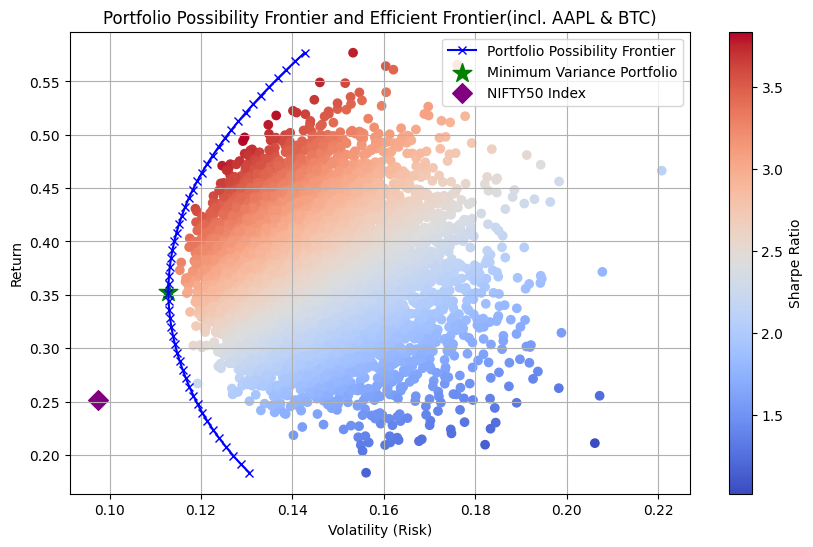

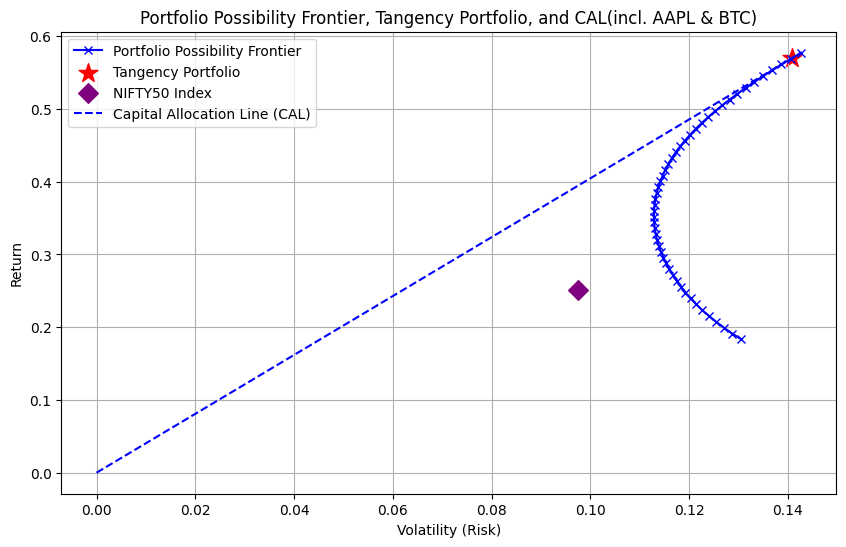

In [ ]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimization

# Constants
NUM_TRADING_DAYS = 244  # Daily trading periods (roughly 244 trading days in a year)
NUM_PORTFOLIOS = 10000
risk_free_rate = 0.06 / NUM_TRADING_DAYS  # Daily risk-free rate (6% annual rate)

# Stocks to handle (including crypto in the second run)
stocks = ['TRIDENT.NS', 'FDC.NS', 'GODREJCP.NS', 'CYIENT.NS', 'QUESS.NS', 'JBMA.NS', 'TATACOMM.NS', 'AAPL', 'BTC-USD']
start_date = '2023-04-01'
end_date = '2024-03-31'

# Download Data efficiently for all stocks
def download_data():
    return yf.download(stocks, start=start_date, end=end_date)['Close']

# Calculate daily returns
def calculate_return(data):
    log_return = np.log(data / data.shift(1))
    return log_return.dropna()

# Portfolio statistics function (return, volatility)
def statistics(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * NUM_TRADING_DAYS
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * NUM_TRADING_DAYS, weights)))
    return np.array([portfolio_return, portfolio_volatility])

# Generate random portfolios
def generate_portfolios(returns):
    portfolio_means, portfolio_risks, portfolio_weights = [], [], []

    for _ in range(NUM_PORTFOLIOS):
        w = np.random.random(len(returns.columns))
        w /= np.sum(w)  # Normalize weights
        portfolio_weights.append(w)
        portfolio_means.append(np.sum(returns.mean() * w) * NUM_TRADING_DAYS)
        portfolio_risks.append(np.sqrt(np.dot(w.T, np.dot(returns.cov() * NUM_TRADING_DAYS, w))))

    return np.array(portfolio_weights), np.array(portfolio_means), np.array(portfolio_risks)

# Minimize portfolio variance
def min_variance(weights, returns):
    return statistics(weights, returns)[1]  # Return only volatility (std dev)

# Minimize negative Sharpe ratio
def min_function_sharpe(weights, returns):
    portfolio_return, portfolio_volatility = statistics(weights, returns)
    return -(portfolio_return - risk_free_rate) / portfolio_volatility

# Efficient Frontier
def efficient_frontier(returns, target_returns):
    frontier_volatility = []
    for target in target_returns:
        constraints = (
            {'type': 'eq', 'fun': lambda x: statistics(x, returns)[0] - target},  # Expected return = target
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}  # Sum of weights = 1
        )
        bounds = tuple((0, 1) for _ in range(len(returns.columns)))
        result = optimization.minimize(
            min_variance, np.ones(len(returns.columns)) / len(returns.columns), args=returns,
            method='SLSQP', bounds=bounds, constraints=constraints
        )
        frontier_volatility.append(result.fun)
    return frontier_volatility

# Optimize portfolio for maximum Sharpe ratio or minimum variance
def optimize_portfolio(returns, opt_type='sharpe'):
    x0 = np.ones(len(returns.columns)) / len(returns.columns)  # Equal weights
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(returns.columns)))

    if opt_type == 'sharpe':
        return optimization.minimize(
            fun=min_function_sharpe, x0=x0, args=returns, method='SLSQP', bounds=bounds, constraints=constraints
        )
    else:
        return optimization.minimize(
            fun=min_variance, x0=x0, args=returns, method='SLSQP', bounds=bounds, constraints=constraints
        )

# Plot the portfolio possibility frontier and efficient frontier
def plot_portfolio_possibility(portfolio_means, portfolio_risks, efficient_volatility, target_returns, optimal_mvp, nifty50_volatility, nifty50_mean_return):
    plt.figure(figsize=(10, 6))

    # Plot the portfolio possibility frontier (PPF)
    plt.scatter(portfolio_risks, portfolio_means, c=(portfolio_means - risk_free_rate) / portfolio_risks, marker='o', cmap='coolwarm')
    plt.colorbar(label='Sharpe Ratio')

    # Plot the efficient frontier (part of the PPF above the MVP)
    plt.plot(efficient_volatility, target_returns, linestyle='-', marker='x', color='blue', label='Portfolio Possibility Frontier')

    # Plot the minimum variance portfolio (MVP)
    plt.scatter(optimal_mvp[1], optimal_mvp[0], color='g', marker='*', s=200, label='Minimum Variance Portfolio')

    # Plot NIFTY50 Index
    plt.scatter(nifty50_volatility, nifty50_mean_return, color='purple', marker='D', s=100, label='NIFTY50 Index')

    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Return')
    plt.title('Portfolio Possibility Frontier and Efficient Frontier(incl. AAPL & BTC)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the efficient frontier, tangency portfolio and CAL
def plot_tangency_portfolio_and_cal(portfolio_means, portfolio_risks, efficient_volatility, target_returns, optimal_sharpe, nifty50_volatility, nifty50_mean_return):
    plt.figure(figsize=(10, 6))

    # Plot the efficient frontier
    plt.plot(efficient_volatility, target_returns, linestyle='-', marker='x', color='blue', label='Portfolio Possibility Frontier')

    # Plot Tangency Portfolio (Max Sharpe)
    plt.scatter(optimal_sharpe[1], optimal_sharpe[0], color='r', marker='*', s=200, label='Tangency Portfolio')

    # Plot NIFTY50 Index
    plt.scatter(nifty50_volatility, nifty50_mean_return, color='purple', marker='D', s=100, label='NIFTY50 Index')

    # Plot Capital Allocation Line (CAL)
    cal_x = np.linspace(0, max(efficient_volatility), 100)
    cal_y = risk_free_rate + (optimal_sharpe[0] - risk_free_rate) / optimal_sharpe[1] * cal_x
    plt.plot(cal_x, cal_y, color='b', linestyle='--', label='Capital Allocation Line (CAL)')

    plt.xlabel('Volatility (Risk)')
    plt.ylabel('Return')
    plt.title('Portfolio Possibility Frontier, Tangency Portfolio, and CAL(incl. AAPL & BTC)')
    plt.legend()
    plt.grid(True)
    plt.show()

def print_optimal_portfolio(optimum, returns, label):
    stats = statistics(optimum['x'].round(3), returns)
    sharpe_ratio = (stats[0] - risk_free_rate) / stats[1]
    print(f"{label} Portfolio: Weights {optimum['x'].round(3)}")
    print(f"Expected Return: {stats[0]:.4f}, Volatility: {stats[1]:.4f}, Sharpe Ratio: {sharpe_ratio:.4f}\n")
    return stats

# Main execution
if __name__ == '__main__':
    data = download_data()
    returns = calculate_return(data)

    # Generate random portfolios
    portfolio_weights, portfolio_means, portfolio_risks = generate_portfolios(returns)

    # Optimize for minimum variance portfolio (MVP)
    optimum_mvp = optimize_portfolio(returns, 'min_variance')
    mvp_stats = print_optimal_portfolio(optimum_mvp, returns, "Minimum Variance")

    # Optimize for maximum Sharpe ratio (Tangency Portfolio)
    optimum_sharpe = optimize_portfolio(returns, 'sharpe')
    tangency_stats = print_optimal_portfolio(optimum_sharpe, returns, "Tangency (Sharpe Optimal)")

    # Calculate NIFTY50 index returns and statistics
    nifty50 = yf.download('^NSEI', start=start_date, end=end_date)['Close']
    nifty50_data = nifty50.to_frame('^NSEI')
    nifty50_returns = calculate_return(nifty50_data)
    nifty50_mean_return = nifty50_returns.mean()[0] * NUM_TRADING_DAYS
    nifty50_volatility = nifty50_returns.std()[0] * np.sqrt(NUM_TRADING_DAYS)
    nifty50_sharpe_ratio = (nifty50_mean_return - risk_free_rate) / nifty50_volatility

    print(f"NIFTY50 Index: Expected Return: {nifty50_mean_return:.4f}, Volatility: {nifty50_volatility:.4f}, Sharpe Ratio: {nifty50_sharpe_ratio:.4f}\n")

    # Plot Portfolio Possibility Frontier (PPF) and Efficient Frontier
    target_returns = np.linspace(min(portfolio_means), max(portfolio_means), 50)
    efficient_volatility = efficient_frontier(returns, target_returns)
    plot_portfolio_possibility(portfolio_means, portfolio_risks, efficient_volatility, target_returns, mvp_stats, nifty50_volatility, nifty50_mean_return)

    # Plot Tangency Portfolio, Efficient Frontier and Capital Allocation Line (CAL)
    plot_tangency_portfolio_and_cal(portfolio_means, portfolio_risks, efficient_volatility, target_returns, tangency_stats, nifty50_volatility, nifty50_mean_return)
